In [1]:
import pandas as pd 
import numpy as np
import os, sys
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import csv

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from shared_functions.gg_sheet_drive import *

### Processing pipeline

In [26]:
with open('D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/autoscaling/test.txt', 'r') as f:
    lines = f.readlines()

In [27]:
lines[:10]

['ix-mia1-02.ix.netcom.com - - [23/Aug/1995:00:00:00 -0400] "GET /ksc.html HTTP/1.0" 200 7087\n',
 'internet-gw.watson.ibm.com - - [23/Aug/1995:00:00:05 -0400] "GET /history/apollo/pad-abort-test-2/pad-abort-test-2.html HTTP/1.0" 200 1292\n',
 'ix-mia1-02.ix.netcom.com - - [23/Aug/1995:00:00:06 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 200 5866\n',
 'internet-gw.watson.ibm.com - - [23/Aug/1995:00:00:08 -0400] "GET /history/apollo/pad-abort-test-2/pad-abort-test-2-info.html HTTP/1.0" 200 1625\n',
 'internet-gw.watson.ibm.com - - [23/Aug/1995:00:00:10 -0400] "GET /history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif HTTP/1.0" 404 -\n',
 '199.4.102.54 - - [23/Aug/1995:00:00:11 -0400] "GET /facilities/tour.html HTTP/1.0" 200 3826\n',
 'www-a1.proxy.aol.com - - [23/Aug/1995:00:00:11 -0400] "GET /history/history.html HTTP/1.0" 304 0\n',
 'internet-gw.watson.ibm.com - - [23/Aug/1995:00:00:11 -0400] "GET /history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif HTTP/

In [28]:
log_pattern = re.compile(
    r'(?P<ip>\S+)\s+'
    r'(?P<identd>\S+)\s+'
    r'(?P<user>\S+)\s+'
    r'\[(?P<time>[^\]]+)\]\s+'
    r'"(?P<request>[^"]*)"\s+'
    r'(?P<status>\d{3})\s+'
    r'(?P<size>\S+)'
)

def extract_info(line):
    match = log_pattern.match(line)
    if not match:
        return None

    d = match.groupdict()

    if d["request"]:
        parts = d["request"].split()
        d["resource"] = parts[1] if len(parts) > 1 else None
        d["protocol"] = parts[2] if len(parts) > 2 else None
    else:
        d["resource"] = d["protocol"] = None

    d["size"] = None if d["size"] == "-" else int(d["size"])
    d["status"] = int(d["status"])

    d['utc'] = f'UTC - {d['time'].split('-')[1][:2]}'

    d["time"] = pd.to_datetime(
        d["time"].split('-')[0].strip(), format="%d/%b/%Y:%H:%M:%S"
    )

    return d

In [ ]:
## Approach 1: Sequential processing

out_path = "test.csv"
write_header = not os.path.exists(out_path)

df = pd.DataFrame(columns=extract_info(lines[0]).columns)

for line in tqdm(lines, desc="Parsing logs"):
    try:
        row = extract_info(line)     # 1-row DataFrame

        # append to csv immediately
        row.to_csv(out_path, mode="a", header=write_header, index=False)
        write_header = False

        # (optional) also keep in memory
        df = pd.concat([df, row], axis=0)

    except Exception as e:
        print(f"Error at line: {line}\n{e}")

df.reset_index(drop=True, inplace=True)

Parsing logs:   0%|          | 0/2934961 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_15712\2484155689.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], axis=0)
Parsing logs:   1%|▏         | 39953/2934961 [06:53<9:53:38, 81.28it/s] 

This is slow due to 

1. pd.concat runs in O(n^2) time complexity
2. reset_index
3. stores everything in RAM

Change to batch streaming + dict instead of pd.df

In [31]:
# Approach 2: Batch streaming

out_path = "test.csv"

fieldnames = list(extract_info(lines[0]).keys())

BATCH_SIZE = 50_000

# lines = lines[:]

with open(out_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    total = len(lines)

    for start in tqdm(range(0, total, BATCH_SIZE), desc="Batches"):
        end = min(start + BATCH_SIZE, total)
        batch = lines[start:end]

        buffer = []
        bad = 0

        for line in batch:
            try:
                d = extract_info(line)
                if d is not None:      
                    buffer.append(d)
                else:
                    bad += 1
            except Exception:
                bad += 1


        if buffer:
            writer.writerows(buffer)
            f.flush()
            os.fsync(f.fileno())

        print(f"Batch {start//BATCH_SIZE + 1}: "
              f"written {len(buffer)}, bad {bad}")


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   9%|▉         | 1/11 [00:22<03:41, 22.11s/it]

Batch 1: written 50000, bad 0


Batches:  18%|█▊        | 2/11 [00:43<03:16, 21.88s/it]

Batch 2: written 50000, bad 0


Batches:  27%|██▋       | 3/11 [01:04<02:48, 21.11s/it]

Batch 3: written 50000, bad 0


Batches:  36%|███▋      | 4/11 [01:24<02:26, 20.87s/it]

Batch 4: written 50000, bad 0


Batches:  45%|████▌     | 5/11 [01:44<02:04, 20.70s/it]

Batch 5: written 49997, bad 3


Batches:  55%|█████▍    | 6/11 [02:04<01:41, 20.24s/it]

Batch 6: written 50000, bad 0


Batches:  64%|██████▎   | 7/11 [02:25<01:21, 20.50s/it]

Batch 7: written 50000, bad 0


Batches:  73%|███████▎  | 8/11 [02:45<01:01, 20.41s/it]

Batch 8: written 50000, bad 0


Batches:  82%|████████▏ | 9/11 [03:06<00:41, 20.64s/it]

Batch 9: written 50000, bad 0


Batches:  91%|█████████ | 10/11 [03:28<00:20, 20.90s/it]

Batch 10: written 50000, bad 0


Batches: 100%|██████████| 11/11 [03:37<00:00, 19.74s/it]

Batch 11: written 26651, bad 0


### Start from here

In [ ]:
df = pd.read_csv("D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/autoscaling/cleaned/train.csv")

df['time'] = pd.to_datetime(df['time'])
df['status'] = df['status'].astype(int)
df['size'] = df['size'].astype(float)

# df['status_label'] = df['status'].apply(
#     lambda x: (
#         'Success' if x == 200 else
#         'No Change' if x == 304 else
#         'Redirected' if x in [301, 302] else
#         'Not Found' if x == 404 else
#         'Error'
#     )
# )

In [13]:
df.shape

(2934932, 11)

In [14]:
df.head(2)

,ip,identd,user,time,request,status,size,resource,protocol,utc,status_label
0,199.72.81.55,-,-,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245.0,/history/apollo/,HTTP/1.0,UTC - 04,Success
1,unicomp6.unicomp.net,-,-,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985.0,/shuttle/countdown/,HTTP/1.0,UTC - 04,Success


(array([9312., 9319., 9326., 9333., 9343., 9350., 9357., 9364.]),
 [Text(9312.0, 0, '1995-07-01'),
  Text(9319.0, 0, '1995-07-08'),
  Text(9326.0, 0, '1995-07-15'),
  Text(9333.0, 0, '1995-07-22'),
  Text(9343.0, 0, '1995-08-01'),
  Text(9350.0, 0, '1995-08-08'),
  Text(9357.0, 0, '1995-08-15'),
  Text(9364.0, 0, '1995-08-22')])

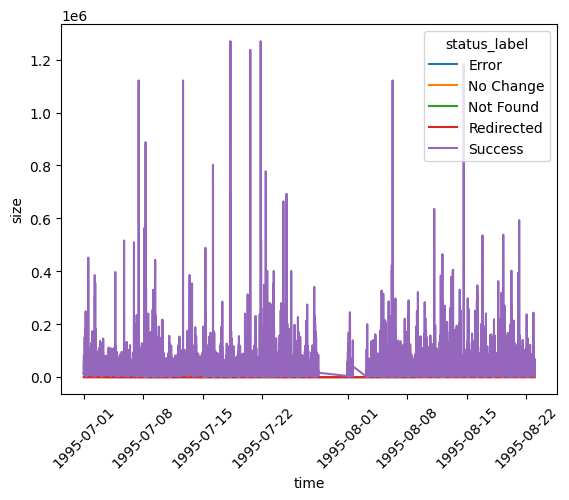

In [ ]:
df["time"] = pd.to_datetime(df["time"])

df_agg = (
    df
    .set_index("time")
    .groupby("status_label")
    .resample("1min", level=0)["size"]
    .mean()
    .reset_index()
)

# test_label = df_agg[df_agg['status_label'] == 'Not Found']

sns.lineplot(data=df_agg, x="time", y="size", hue="status_label")
plt.xticks(rotation=45)

| Status                             | Meaning                         | What it means in your data                                                                         |
| ---------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------- |
| **200 OK**                         | Request succeeded               | The page or API endpoint was returned correctly.                                                   |
| **304 Not Modified**               | Cached version is still valid   | The client already had the resource and the server said “no change”. Common for static files.      |
| **302 Found (Temporary Redirect)** | Redirect to another URL         | The server redirected the user (e.g., login, HTTPS redirect, or URL change).                       |
| **404 Not Found**                  | Resource does not exist         | Broken links, missing pages, bad URLs, or crawlers probing random paths.                           |
| **403 Forbidden**                  | Access denied                   | The client is blocked or lacks permission (IP blocked, auth required).                             |
| **500 Internal Server Error**      | Server crashed while processing | Bug, memory error, timeout, or bad backend logic.                                                  |
| **501 Not Implemented**            | Method not supported            | The server doesn’t recognize the request method (e.g., PUT on a server that only allows GET/POST). |
| **400 Bad Request**                | Malformed request               | Invalid syntax, missing parameters, or corrupted requests.                                         |


After Normalized: 

200 -> Success

304 -> No Change

302 -> Redirected

404 -> Not Found

Others -> Error